In [1]:
from espressomd import System, interactions, electrostatics
from espressomd.io.writer import vtf

import numpy as np
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt


Theory: this notebook introduces electrostatics methods (it will replace the current tutorial for charged systems). The physical goal is to study counterion condensation around a charged rod (simple cell model for a polyelectrolyte) and recreate some of the results from "Deserno, Markus, Christian Holm, and Sylvio May. "Fraction of condensed counterions around a charged rod: Comparison of Poisson− Boltzmann theory and computer simulations." Macromolecules 33.1 (2000): 199-206."

In [2]:

# system parameters
rod_length = 24.
bjerrum_length = 1.0
kT = 1.

#this tutorial assumes a unit system in which the elementary charge is 1

In [3]:
system = System(box_l=3*[rod_length])
system.time_step = 0.01
system.cell_system.skin = 0.4

In [4]:
wca_epsilon = 1.0
ion_diameter = 1.0
rod_radius = 1.0

# particle types 
rod_type = 1
counterion_type = 2

#ion-ion interaction
system.non_bonded_inter[counterion_type,counterion_type].wca.set_params(
      epsilon=wca_epsilon, sigma=ion_diameter)

# ion-rod interaction
system.non_bonded_inter[counterion_type,rod_type].wca.set_params(
      epsilon=wca_epsilon, sigma=ion_diameter/2. + rod_radius)

In [5]:
def setup_rod_and_ions(system, ion_valency, counterion_type,
                 rod_line_charge, N_rod_beads, rod_type):
    
    # calculate charge of the single rod beads
    total_rod_charge = rod_charge_dens*system.box_l[0]
    rod_charge_per_bead = total_rod_charge/N_rod_beads
    
    # number of counterions
    N_ions = int(total_rod_charge/ion_valency)
    
    assert(abs((total_rod_charge-N_ions*ion_valency)/total_rod_charge)<1e-8)
    
    for idx in range(N_rod_beads):
        system.part.add(pos=[rod_length/2.,rod_length/2.,idx/N_rod_beads], 
                        type=rod_type, q=rod_charge_per_bead, fix=3*[True])

    for _ in range(N_ions):
        system.part.add(pos=np.random.random(3) * system.box_l, 
                        type=counterion_type, q=-ion_valency)
    

In [6]:
counterion_valency = 1
rod_charge_dens = 1

# number of beads that make up the rod
N_rod_beads = 50


setup_rod_and_ions(system, counterion_valency, counterion_type,
             rod_charge_dens, N_rod_beads, rod_type)

In [7]:
p3m_params = {'prefactor':kT*bjerrum_length,
              'accuracy':1e-3}
p3m = electrostatics.P3M(**p3m_params)
system.actors.add(p3m)

P3M tune parameters: Accuracy goal = 1.00000e-03 prefactor = 1.00000e+00
System: box_l = 2.40000e+01 # charged part = 74 Sum[q_i^2] = 3.55200e+01
mesh cao r_cut_iL     alpha_L      err          rs_err     ks_err     time [ms]
4    7   cao too large for this mesh
8    7   2.67155e-01 7.17025e+00 9.94171e-04 7.071e-04 6.988e-04 0.59    
8    6   2.69987e-01 7.08993e+00 9.95810e-04 7.071e-04 7.012e-04 0.31    
8    5   2.77539e-01 6.88402e+00 9.96811e-04 7.071e-04 7.026e-04 0.26    
8    4   2.95475e-01 6.43834e+00 9.96167e-04 7.071e-04 7.017e-04 0.22    
8    3   3.37012e-01 5.59330e+00 9.94603e-04 7.071e-04 6.995e-04 0.22    
8    2   4.83333e-01 3.79978e+00 1.09024e-03 7.071e-04 8.298e-04 accuracy not achieved
10   4   2.45268e-01 7.85546e+00 9.96622e-04 7.071e-04 7.023e-04 0.25    
10   3   2.79894e-01 6.82216e+00 9.96133e-04 7.071e-04 7.016e-04 0.23    
10   5   2.30263e-01 8.40285e+00 9.95529e-04 7.071e-04 7.008e-04 0.29    
10   2   2.95475e-01 6.43834e+00 2.13250e-03 7.071e-04 2.0

In [8]:
def remove_overlap(system, sd_params):   
    #remove overlap by steepest descent
    # Set up steepest descent integration
    system.integrator.set_steepest_descent(f_max=0,
                                           gamma=sd_params['damping'],
                                           max_displacement=sd_params['max_displacement'])
    
    # Initialize integrator to obtain initial forces
    system.integrator.run(0)
    maxforce = np.max(np.linalg.norm(system.part[:].f, axis = 1))
    energy = system.analysis.energy()['total']
    
    i = 0
    while i < sd_params['max_steps']//sd_params['emstep']:
        prev_maxforce = maxforce
        prev_energy = energy
        print(prev_energy)
        system.integrator.run(sd_params['emstep'])
        maxforce = np.max(np.linalg.norm(system.part[:].f, axis = 1))
        relforce = np.abs((maxforce-prev_maxforce)/prev_maxforce)
        energy = system.analysis.energy()['total']
        relener = np.abs((energy-prev_energy)/prev_energy)
        print("minimization step: {:4.0f}\tmax. rel. force change:{:+3.3e}\trel. energy change:{:+3.3e}".format((i+1)*sd_params['emstep'],relforce, relener))
        if relforce < sd_params['f_tol'] or relener < sd_params['e_tol']:
            break
        i += 1
        
    system.integrator.set_vv()

In [9]:
#steepest descent params
STEEPEST_DESCENT_PARAMS = {'f_tol':1e-2,
                          'e_tol':1e-5,
                          'damping':30,
                          'max_steps':10000,
                          'max_displacement':0.01,
                          'emstep':10}

remove_overlap(system,STEEPEST_DESCENT_PARAMS)

1987.2271703882295
minimization step:   10	max. rel. force change:+9.267e-07	rel. energy change:+4.259e-04


In [10]:
langevin_params = {'kT':kT,
                   'gamma':0.5,
                   'seed':42}
system.thermostat.set_langevin(**langevin_params)

In [11]:
#introduce ion_types as an iterable here already. 
#For this part it could be an int, but we will add additional salt ions later

def integrate_calc_observables(system, N_frames, steps_per_frame, ion_types):
    energies = []
    radial_distances = []
    
    particles_by_type = {}
    radial_distances = {}
    for ion_type in ion_types:
        particles_by_type[ion_type] = system.part.select(type=ion_type)
        radial_distances[ion_type] = []
    
    system_center = np.array(system.box_l)/2.
    
    for _ in range(N_frames):
        # run run the simulation for a few steps
        system.integrator.run(steps_per_frame)

        energies.append(system.analysis.energy()['total'])
        
        for ion_type, ions in particles_by_type.items():
            for ion in ions:
                radial_distances[ion_type].append(np.linalg.norm(ion.pos_folded[0:2]-system_center[0:2]))
    
    return energies, radial_distances




In [12]:
# before we do a run to produce histogram data, we look at energies to see how long it takes until equilibration and what the fluctuation timescale is

# number of samples taken
N_frames = 100

# number of timesteps per frame
steps_per_frame = 300
energies, _ = integrate_calc_observables(system, N_frames, 
                                       steps_per_frame, [counterion_type])

Text(0, 0.5, 'system total energy')

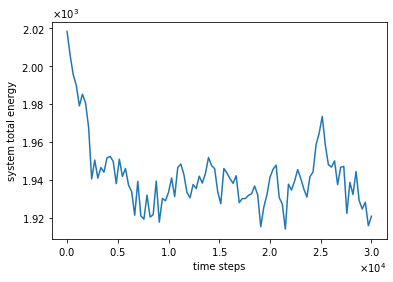

In [13]:
plt.ion()
ts = np.linspace(0,N_frames*steps_per_frame, num = N_frames)
fig1 = plt.figure()
#plot time in time_steps so we can judge the number of warmup steps and the steps per frame for uncorrelated data
plt.plot(ts, energies)
plt.xlabel('time steps')
plt.ylabel('system total energy')

In [23]:
#use the plot to determine the warmup time and the appropriate number of steps per frame
warmup_steps = 5000

N_frames = 1000
steps_per_frame = 200

In [24]:
def clear_system(system):
    system.thermostat.turn_off()
    system.part.clear()
    system.time = 0.
    

In [25]:
clear_system(system)

In [26]:
#TODO replace this function by more intuitive behaviour of p3m.tune()
def retune_p3m(p3m):
    #reset p3m tunable parameters to default to force a retune
    p3m_default_params = p3m.default_params()
    p3m.tune(mesh = p3m_default_params['mesh'],
             cao = p3m_default_params['cao'],
             r_cut = 0,
             #TODO change default value in interface
             alpha = p3m_default_params['alpha'])

In [27]:
#run the system with different parameter sets but same manning parameter
runs = [{'params':{'counterion_valency':2, 'rod_charge_dens':1},
         'distances':None},
        {'params':{'counterion_valency':1, 'rod_charge_dens':2},
         'distances':None}
       ]

for run in runs:
    setup_rod_and_ions(system, run['params']['counterion_valency'], counterion_type,
                 run['params']['rod_charge_dens'], N_rod_beads, rod_type)
    retune_p3m(p3m)
    remove_overlap(system, STEEPEST_DESCENT_PARAMS)
    system.thermostat.set_langevin(**langevin_params)
    system.integrator.run(warmup_steps)
    print('setup and warmup done, starting simulation')
    energies, distances = integrate_calc_observables(system, N_frames, 
                                       steps_per_frame, [counterion_type])
    clear_system(system)
    run['distances'] = distances[counterion_type]
    print('simulation for parameters {} done\n'.format(run['params']))

P3M tune parameters: Accuracy goal = 9.93425e-04 prefactor = 1.00000e+00
System: box_l = 2.40000e+01 # charged part = 62 Sum[q_i^2] = 5.95200e+01
mesh cao r_cut_iL     alpha_L      err          rs_err     ks_err     time [ms]
4    7   cao too large for this mesh
6    7   cao too large for this mesh
10   7   2.54883e-01 8.13964e+00 9.85042e-04 7.025e-04 6.906e-04 0.40    
10   6   2.60547e-01 7.95252e+00 9.83617e-04 7.025e-04 6.885e-04 0.33    
10   5   2.70931e-01 7.63029e+00 9.89064e-04 7.025e-04 6.963e-04 0.37    
10   4   2.91699e-01 7.05635e+00 9.88106e-04 7.025e-04 6.949e-04 0.25    
10   3   3.42676e-01 5.94928e+00 9.93236e-04 7.025e-04 7.022e-04 0.25    
10   2   4.83333e-01 4.12977e+00 1.34822e-03 7.025e-04 1.151e-03 accuracy not achieved
12   3   2.94487e-01 6.98562e+00 9.91635e-04 7.025e-04 6.999e-04 0.28    
12   2   3.42676e-01 5.94928e+00 2.09171e-03 7.025e-04 1.970e-03 accuracy not achieved
12   4   2.48975e-01 8.34411e+00 9.92152e-04 7.025e-04 7.007e-04 0.30    
12   5  

setup and warmup done, starting simulation
simulation for parameters {'counterion_valency': 1, 'rod_charge_dens': 2} done



In [28]:
#Q: why does the second simulation take much longer?
#A: double the charge, half the valency => 4x more ions to be integrated

In [55]:
def calc_cum_hist(values, bins, normalize = True):
    hist, bins = np.histogram(values, bins=log_bins)
    cum_hist = np.cumsum(hist)
    if normalize:
        cum_hist = cum_hist/cum_hist[-1]
    return cum_hist

Text(0, 0.5, 'P(r)')

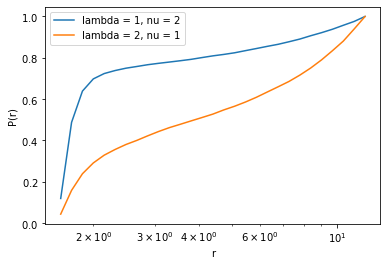

In [39]:
log_bins=np.logspace(np.log10(rod_radius+ion_diameter/2.), np.log10(rod_length/2.),num=30)

fig, ax = plt.subplots()
for run in runs:
    cum_hist = calc_cum_hist(run['distances'], log_bins)
    ax.plot(log_bins[1:],cum_hist, label = 'lambda = {}, nu = {}'.format(run['params']['rod_charge_dens'], 
                                                                          run['params']['counterion_valency']))
    
ax.set_xscale('log')
ax.legend()
plt.xlabel('r')
plt.ylabel('P(r)')

In [40]:
def eq_to_solve_for_gamma(gamma, manning_parameter, rod_radius, max_radius):
    #eq 7 - eq 6 from 10.1021/ma990897o
    return gamma*np.log(max_radius/rod_radius) - np.arctan(1/gamma) + np.arctan((1-manning_parameter)/gamma)

def calc_manning_radius(gamma,max_radius):
    #eq 7 from 10.1021/ma990897o
    return max_radius*np.exp(-np.arctan(1./gamma)/gamma)  

def calc_PB_probability(r, manning_parameter, gamma, manning_radius):
    #eq 8 and 9 from 10.1021/ma990897o
    return 1./manning_parameter + gamma/manning_parameter * np.tan(gamma*np.log(r/manning_radius))


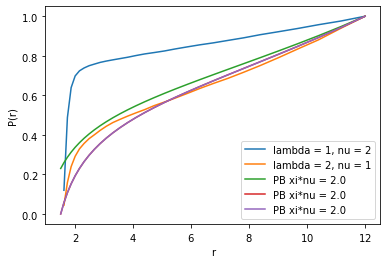

In [45]:
rod_charge_density = runs[0]['params']['rod_charge_dens']
ion_valency = runs[0]['params']['counterion_valency']
manning_parameter_times_valency = bjerrum_length*rod_charge_density*ion_valency
#for multivalent ions, the manning parameter xi has to be multiplied by the valency.
#the result therefore depends only on the product of rod_charge_dens and ion_velancy, so we only need one curve

gamma = optimize.fsolve(eq_to_solve_for_gamma, 1, args = (manning_parameter_times_valency,rod_radius+ion_diameter/2.,rod_length/2.))
manning_radius = calc_manning_radius(gamma, rod_length/2.)

PB_probability = calc_PB_probability(log_bins, manning_parameter_times_valency,gamma, manning_radius)


ax.plot(log_bins, PB_probability, label = f'PB xi*nu = {manning_parameter_times_valency}')
ax.legend()
ax.set_xscale('linear')
fig

In [46]:
# overcharging through added salt

In [47]:
def add_salt(system, anion_params, cation_params):        
    for _ in range(anion_params['number']):
        system.part.add(pos=np.random.random(3) * system.box_l, 
                        type=anion_params['type'], q=-anion_params['valency'])
        
    for _ in range(cation_params['number']):
        system.part.add(pos=np.random.random(3) * system.box_l, 
                        type=cation_params['type'], q=cation_params['valency'])
    

In [71]:
anion_params = {'type':3,
                'valency':2,
                'number':300}
cation_params = {'type':4,
                 'valency':2,
                 'number':300}

total_anion_charge = -anion_params['number']*anion_params['valency']
total_cation_charge = cation_params['number']*cation_params['valency']
assert( abs(total_anion_charge+ total_cation_charge)/total_cation_charge < 1e-10)

counterion_valency = 1 
rod_charge_dens = 1

all_ion_types = [counterion_type, anion_params['type'],cation_params['type'] ]

#set interactions of salt with the rod and all ions
for salt_type in [anion_params['type'], cation_params['type']]:
    system.non_bonded_inter[salt_type,rod_type].wca.set_params(
          epsilon=wca_epsilon, sigma=ion_diameter/2. + rod_radius)
    for ion_type in all_ion_types:
        system.non_bonded_inter[salt_type,ion_type].wca.set_params(
          epsilon=wca_epsilon, sigma=ion_diameter)
    



In [72]:
clear_system(system)
setup_rod_and_ions(system, counterion_valency, counterion_type,
                   rod_charge_dens, N_rod_beads, rod_type)
add_salt(system, anion_params, cation_params)
retune_p3m(p3m)
remove_overlap(system, STEEPEST_DESCENT_PARAMS)
system.thermostat.set_langevin(**langevin_params)
system.integrator.run(warmup_steps)
print('setup and warmup done, starting simulation')
energies, distances = integrate_calc_observables(system, N_frames, 
                                   steps_per_frame, all_ion_types)
print('simulation done')


P3M tune parameters: Accuracy goal = 9.64898e-04 prefactor = 1.00000e+00
System: box_l = 2.40000e+01 # charged part = 674 Sum[q_i^2] = 2.43552e+03
mesh cao r_cut_iL     alpha_L      err          rs_err     ks_err     time [ms]
10   7   4.20085e-01 6.11650e+00 9.60822e-04 6.823e-04 6.765e-04 9.10    
10   6   4.38965e-01 5.84367e+00 9.62716e-04 6.823e-04 6.792e-04 8.82    
10   5   4.73893e-01 5.39719e+00 9.60810e-04 6.823e-04 6.765e-04 10.10   
10   4   4.83333e-01 5.28779e+00 1.67294e-03 6.823e-04 1.527e-03 accuracy not achieved
12   6   3.72091e-01 6.93707e+00 9.63431e-04 6.823e-04 6.802e-04 5.95    
12   5   4.02099e-01 6.40067e+00 9.61529e-04 6.823e-04 6.775e-04 6.63    
12   7   3.56659e-01 7.24872e+00 9.57051e-04 6.823e-04 6.711e-04 5.96    
14   6   3.23400e-01 8.02342e+00 9.64023e-04 6.823e-04 6.810e-04 4.50    
14   5   3.50289e-01 7.38551e+00 9.58306e-04 6.823e-04 6.729e-04 4.90    
14   7   3.10318e-01 8.37445e+00 9.53394e-04 6.823e-04 6.659e-04 4.68    
16   6   2.86765e-01

Text(0, 0.5, 'P(r)')

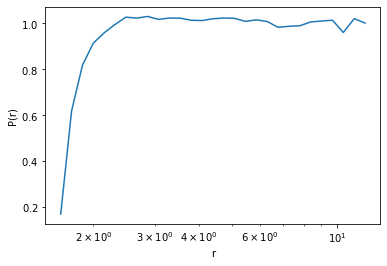

In [75]:
#do not normalize the histograms because there are a different number of the ion types
counterion_hist = calc_cum_hist(distances[counterion_type], log_bins, normalize = False)
anion_hist = calc_cum_hist(distances[anion_params['type']], log_bins, normalize = False)
cation_hist = calc_cum_hist(distances[cation_params['type']], log_bins, normalize = False)

charge_hist = cation_params['valency'] * cation_hist - anion_params['valency'] * anion_hist - counterion_valency * counterion_hist
charge_hist = charge_hist/charge_hist[-1]
#we know the system in total is neutral, so we can normalize the total histogram to the rod charge


fig2, ax2 = plt.subplots()
#normalize the histogram by the rod charge
ax2.plot(log_bins[1:], charge_hist)
ax2.set_xscale('log')
plt.xlabel('r')
plt.ylabel('P(r)')



In [ ]:
#theoretical curve for the salt


In [74]:
def calc_mu_from_y(rs,ys,valency):
    integrand = rs*np.exp(-valency*ys)
    integral = scipy.integrate.simps(integrand, x=rs)
    r_max = rs[-1]
    #V = 2*np.pi*r_max**2, integration over angle yields 2*np.pi
    return np.log(1./r_max**2*integral)
    

In [ ]:
def calc_PBE_right_side(y, valencies, concentrations, chempots, prefactor=-4*np.pi):
    #assumes that valencies_concentrations is a list of tuples of signed valencies, avg concentrations, chemical potentials
    sum = 0.
    for valency, concentration, chempots in zip(valencies, concentrations, chempots):
        sum += valency*concentration*np.exp(-valency*y)/chempot
    return prefactor*sum
   

In [ ]:
def calc_vector_PBE(y,r,valencies, concentrations, chempots):
    #rewrite second order one component to first order two component vec(y) = [y, y']
    return [y[1], calc_PBE_right_side(y, valencies, concentrations, chempots) - y[0]/r]


In [ ]:
def root_target_fcn(chempots, valencies, concentrations):
    #solve vector_PBE for y
    #scipy rk4...
    
    chempot_from_y = []
    for valency in valencies:
        chempot_from_y.append(calc_mu_from_y(rs,ys,valency))
    
    return np.linalg.norm(chempots-chempots_from_y)

In [ ]:
def calc_PB_probability_salt(rs,ys,valencies, concentrations, chempots, prefactor = 1):
    integrand = 1
    integral = 1
    return prefactor*integral